In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

from readers import reader
from config import RECORDING_FILE

In [2]:
NPreader = reader.NeuropixelsReader("W:\Large_scale_mapping_NP\Awake_exp\SA6\SA6_experiment_4_9_23\Insertion4\SA6_experiment_4_9_23_4_g0\SA6_experiment_4_9_23_4_g0_t0.nidq.bin")
channels = [0, 1, 10]  # Example channels
start_times = [0, 1000]  # Start times in ms
window=100 #  in ms
conv_to_uv=False
data, time = NPreader.read_data(channels, start_times, window, convert_to_uv=conv_to_uv)

TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [14]:
list(NPreader.channel_map.keys())

[0, 1, 2, 3, 4, 5, 6, 7, 8]

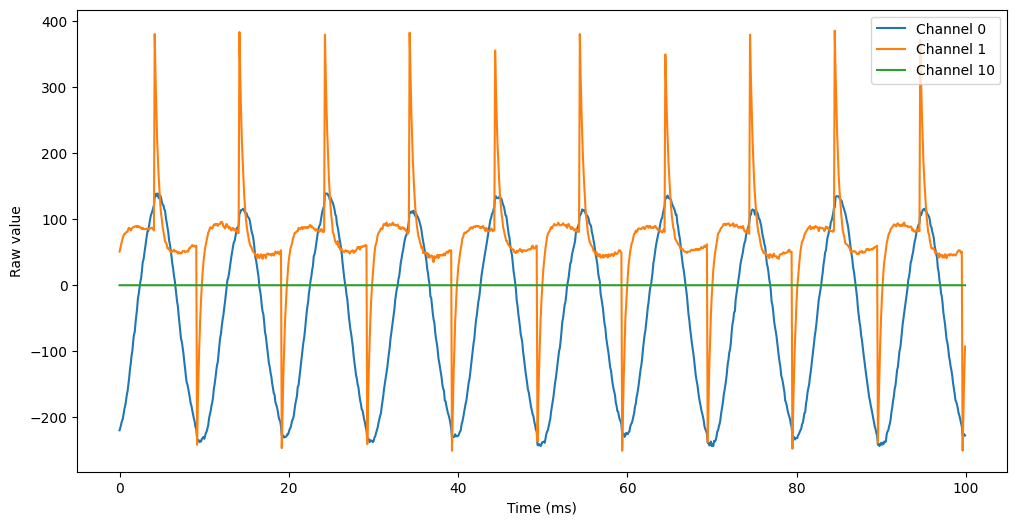

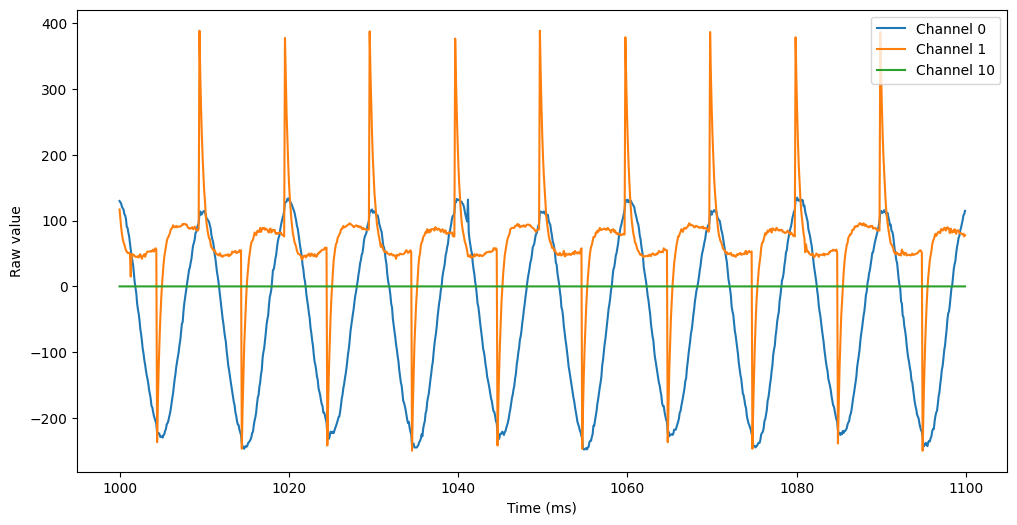

In [10]:
for j in range(data.shape[0]):

    fig, ax = plt.subplots(figsize=(12, 6))
    for i in range(data.shape[1]):
        ax.plot(time[j], data[j, i, :], label=f'Channel {channels[i]}')

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Voltage (uV)' if conv_to_uv else 'Raw value')

    ax.legend()

    plt.show()

In [13]:
from config import RECORDING_FILE_1
NPreader = reader.NeuropixelsReader(RECORDING_FILE_1)
channels = [0, 99, 199]  # Example channels
start_times = [0, 1000]  # Start times in ms
window=100 #  in ms
conv_to_uv=False
data_1, time = NPreader.read_data(channels, start_times, window, convert_to_uv=conv_to_uv)

In [14]:
data[0][1][:20]

array([ 0,  0,  5,  3, 14,  6,  7, -6, -2,  1,  2,  1, 13,  1,  5,  8, -2,
       -2, -4, -2], dtype=int16)

In [15]:
data_1[0][1][:20]

array([ 0,  0,  5,  2, 13,  6,  7, -5, -2,  1,  1,  0, 12,  2,  3,  9, -2,
       -1, -4, -1], dtype=int16)

In [17]:
NPreader.metadata

{'acqApLfSy': '384,384,1',
 'appVersion': '20230411',
 'catGTCmdline0': '<CatGT -dir=//132.66.45.127/data//Large_scale_mapping_NP/Awake_exp/SA6/SA6_experiment_4_9_23/Insertion4 -run=SA6_experiment_4_9_23_4 -g=0 -t=0 -prb_fld -t_miss_ok -ap -prb=0 -zerofillmax=0 -dest=//132.66.45.127/data//Large_scale_mapping_NP/Awake_exp/SA6/SA6_experiment_4_9_23/Insertion4>',
 'catGVals': '0,0',
 'catNFiles': '1',
 'catTVals': '0,0',
 'fileCreateTime': '2023-09-05T13:35:25',
 'fileCreateTime_original': '2023-09-04T20:00:22',
 'fileName': '//132.66.45.127/data//Large_scale_mapping_NP/Awake_exp/SA6/SA6_experiment_4_9_23/Insertion4/catgt_SA6_experiment_4_9_23_4_g0/SA6_experiment_4_9_23_4_g0_tcat.imec0.ap.bin',
 'fileSHA1': '0',
 'fileSizeBytes': '303510273990',
 'fileTimeSecs': '13138.804496076264',
 'firstSample': '76409793',
 'gateMode': 'Immediate',
 'imAiRangeMax': '0.6',
 'imAiRangeMin': '-0.6',
 'imAnyChanFullBand': 'true',
 'imCalibrated': 'true',
 'imChan0apGain': '500',
 'imDatApi': '3.60',
 'im

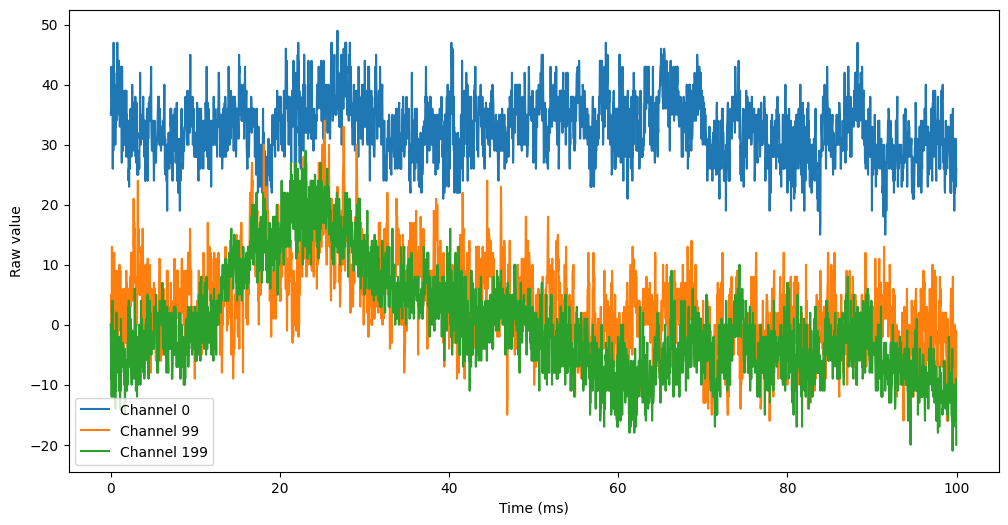

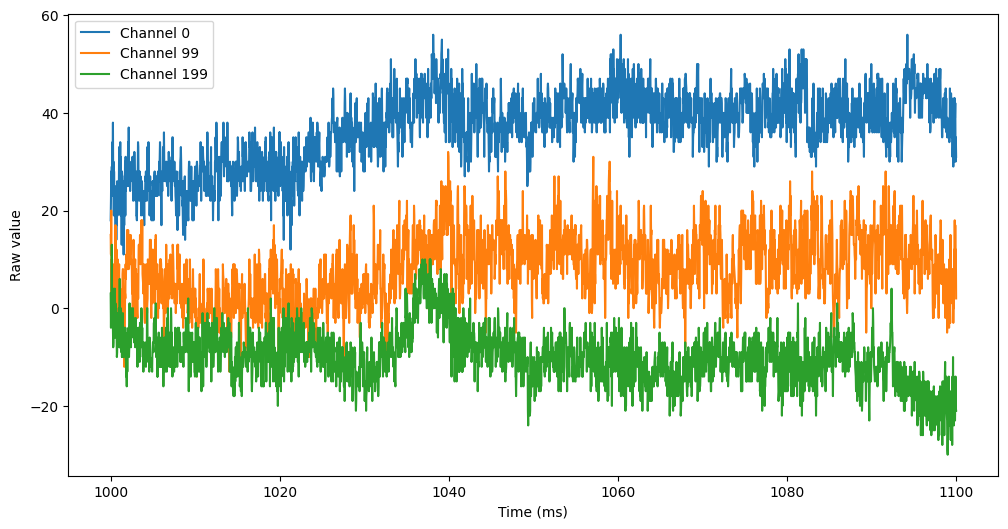

In [16]:
for j in range(data.shape[0]):

    fig, ax = plt.subplots(figsize=(12, 6))
    for i in range(data.shape[1]):
        ax.plot(time[j], data_1[j, i, :], label=f'Channel {channels[i]}')

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Voltage (uV)' if conv_to_uv else 'Raw value')

    ax.legend()

    plt.show()

In [4]:
import numpy as np
import h5py
f = h5py.File('../data_to_compare/get_data_1,100,200_0_100.mat', 'r')
data_matlab_0 = f.get('LFP')
data_matlab_0 = np.array(data_matlab_0) # For converting to a NumPy array

print('mse:', ((data[0].reshape(-1) - np.transpose(data_matlab_0).reshape(-1))**2).mean())

mse: 3.141892743556584e-29


In [5]:
f = h5py.File('../data_to_compare/get_data_1,100,200_1000_100.mat', 'r')
data_matlab_0 = f.get('LFP')
data_matlab_0 = np.array(data_matlab_0) # For converting to a NumPy array

print('mse:', ((data[1].reshape(-1) - np.transpose(data_matlab_0).reshape(-1))**2).mean())

mse: 5.260282288194751e-29


In [6]:
NPreader = reader.NeuropixelsReader("W:\Large_scale_mapping_NP\Awake_exp\SA6\SA6_experiment_4_9_23\Insertion4\catgt_SA6_experiment_4_9_23_4_g0\SA6_experiment_4_9_23_4_g0_tcat.imec0.lf.bin")
channels = [384, 384+99, 384+199]  # Example channels
start_times = [0, 1000]  # Start times in ms
window=100 #  in ms
conv_to_uv=True
data, time = NPreader.read_data(channels, start_times, window, convert_to_uv=conv_to_uv)

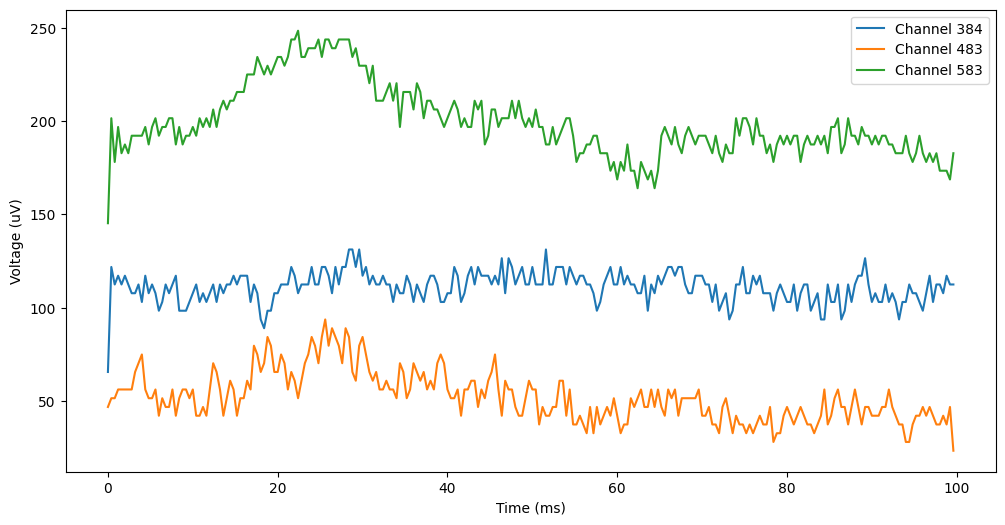

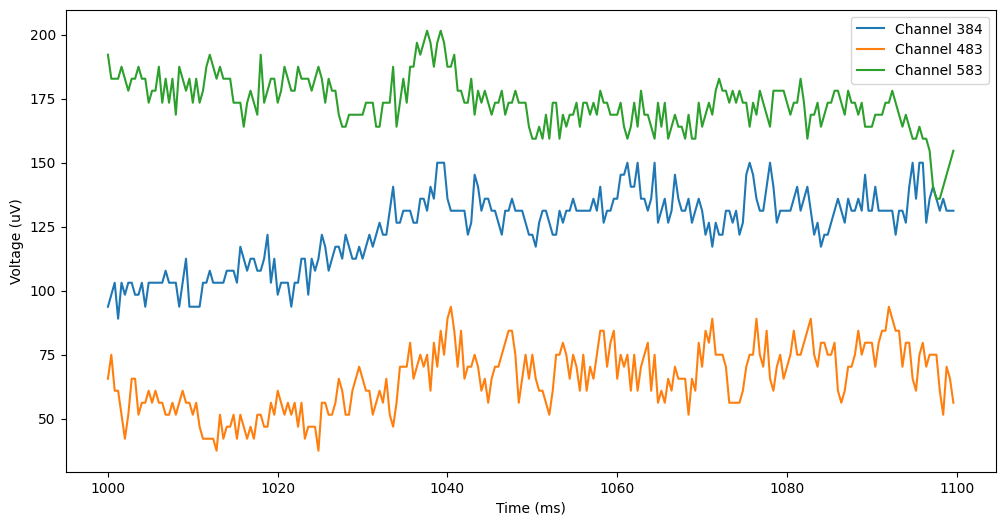

In [7]:
for j in range(data.shape[0]):

    fig, ax = plt.subplots(figsize=(12, 6))
    for i in range(data.shape[1]):
        ax.plot(time[j], data[j, i, :], label=f'Channel {channels[i]}')

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Voltage (uV)' if conv_to_uv else 'Raw value')

    ax.legend()

    plt.show()

In [8]:
f = h5py.File('../data_to_compare/get_data_lfp_1,100,200_0_100.mat', 'r')
data_matlab_0 = f.get('LFP')
data_matlab_0 = np.array(data_matlab_0) # For converting to a NumPy array

print('mse:', ((data[0].reshape(-1) - np.transpose(data_matlab_0).reshape(-1))**2).mean())

mse: 3.475531821786525e-28


In [9]:
f = h5py.File('../data_to_compare/get_data_lfp_1,100,200_1000_100.mat', 'r')
data_matlab_0 = f.get('LFP')
data_matlab_0 = np.array(data_matlab_0) # For converting to a NumPy array

print('mse:', ((data[1].reshape(-1) - np.transpose(data_matlab_0).reshape(-1))**2).mean())

mse: 2.9053641957835837e-28
